<a href="https://colab.research.google.com/github/RoMoRoToR/Article_on_pH_recognition/blob/master/version_5_3_with_circle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [22]:
def generate_image(filename, min_dist, edge_threshold, centre_threshold, min_radius, max_radius):
    src = cv2.imread(cv2.samples.findFile(filename), cv2.IMREAD_COLOR)
    gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(gray, 5)  # TODO: make interactive
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, min_dist,
                              param1=edge_threshold, param2=centre_threshold,
                              minRadius=min_radius, maxRadius=max_radius)
    circle_coords = None
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            center = (i[0], i[1])  # circle center
            cv2.circle(src, center, 1, (0, 100, 100), 3)
            radius = i[2]  # circle outline
            cv2.circle(src, center, radius, (255, 0, 255), 3)
        circle_coords = circles[0, 0]  # Assuming only one circle is detected

    text_loc = (100, 100)
    inverted_color = (int(255 - src[text_loc][0]), int(255 - src[text_loc][1]), int(255 - src[text_loc][2]))
    cv2.putText(src, "{} circles".format(circles.shape[1]), text_loc, cv2.FONT_HERSHEY_SIMPLEX, 1.5, inverted_color)

    return src, circle_coords

In [23]:
def gray_world_balance(image):
    """Баланс белого по алгоритму 'Серый мир'."""
    avg_bgr = np.mean(image, axis=(0, 1))
    gain = np.mean(avg_bgr) / avg_bgr
    white_balanced_img = (image * gain).clip(0, 255).astype(np.uint8)
    return white_balanced_img

In [24]:
def convert_to_lab_and_normalize(image):
    """Преобразование изображения в LAB и нормализация L-компонента."""
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
    l, a, b = cv2.split(lab_image)
    l[:] = 50  # установка L-компонента в 50 для всех пикселей
    normalized_lab = cv2.merge([l, a, b])
    return cv2.cvtColor(normalized_lab, cv2.COLOR_Lab2BGR)

In [25]:
def apply_clahe(image):
    """Применение CLAHE для улучшения контрастности изображения."""
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    lab[:, :, 0] = clahe.apply(lab[:, :, 0])
    return cv2.cvtColor(lab, cv2.COLOR_Lab2BGR)

In [26]:
# Словарь с данными
test_samples_lab = {
    (216, 179): 8.0,
    (172, 152): 7.7,
    (171, 161): 7.5,
    (163, 183): 7.2,
    (192, 205): 6.9,
    (150, 195): 6.5,
    (181, 215): 6.3,
    (118, 188): 6.0,
    (114, 203): 5.7,
}

In [47]:
# Загрузка изображения
image_path = '7.2.png'
image = cv2.imread(image_path)

In [48]:
# Применение предобработки
white_balanced_image = gray_world_balance(image)
lab_normalized_image = convert_to_lab_and_normalize(white_balanced_image)
final_image = apply_clahe(lab_normalized_image)

In [49]:
# Получение изображения с выделенным кругом
image_with_circle, circle_coords = generate_image(image_path, min_dist=50, edge_threshold=50, centre_threshold=50, min_radius=0, max_radius=0)


Estimated pH: 7.7


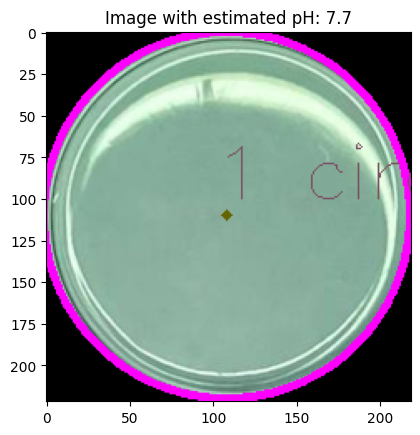

In [50]:
if circle_coords is not None:
    # Вычисление среднего LAB цвета изображения
    lab_image = cv2.cvtColor(final_image, cv2.COLOR_BGR2Lab)
    mean_lab_color = np.mean(lab_image.reshape(-1, 3), axis=0)

    # Поиск ближайшего значения pH
    a_b_values = np.array([values[1:] for values in test_samples_lab.keys()])  # Извлекаем только a и b компоненты
    distances = np.linalg.norm(a_b_values - mean_lab_color[1:], axis=1)
    nearest_index = np.argmin(distances)
    nearest_ph_value = list(test_samples_lab.values())[nearest_index]

    print(f"Estimated pH: {nearest_ph_value}")

    # Визуализация результатов
    plt.imshow(cv2.cvtColor(image_with_circle, cv2.COLOR_BGR2RGB))
    plt.title(f'Image with estimated pH: {nearest_ph_value}')
    plt.show()
else:
    print("Circle not found in the image.")